In [3]:
from tensorflow.keras.datasets.mnist import load_data

(train_images, train_labels), (val_images, val_labels) = load_data()

print('Train:', train_images.shape, train_labels.shape)
print('Val:', val_images.shape, val_labels.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train: (60000, 28, 28) (60000,)
Val: (10000, 28, 28) (10000,)


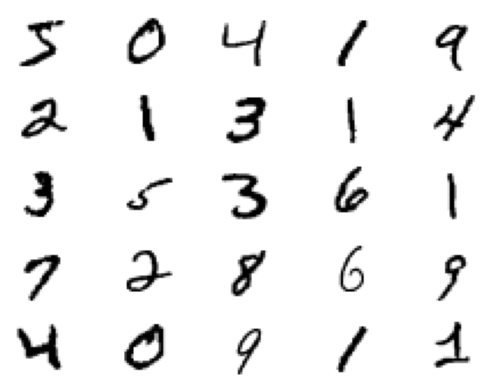

In [4]:
from matplotlib import pyplot as plt

for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.axis('off')
  plt.imshow(train_images[i], cmap='gray_r')

plt.show()

In [5]:
import tensorflow as tf

In [6]:
train_images = tf.expand_dims(train_images, axis=-1)
train_images = train_images / 255
print(train_images.shape)

(60000, 28, 28, 1)


In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Reshape, Dense, Input, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout, Flatten, Conv2D

In [10]:
def create_generator_model():
  model = Sequential()
  model.add(Input(shape=(100,)))
  model.add(Dense(7*7*256, use_bias=False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256)
  model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(64, (7, 7), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 28, 28, 1)

  return model

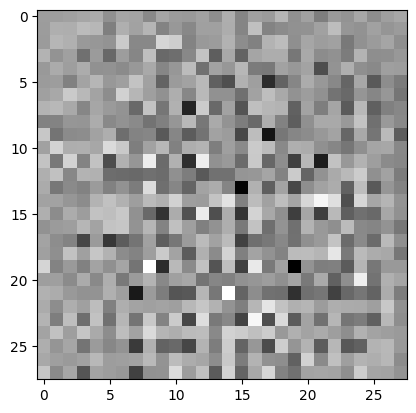

In [11]:
generator = create_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [12]:
def create_discriminator_model():
  model = Sequential()
  model.add(Input(shape=(28, 28, 1)))
  model.add(Conv2D(32, (3, 3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU())
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
  model.add(LeakyReLU())
  model.add(Dropout(0.25))

  model.add(Conv2D(128, (7, 7), strides=(2, 2), padding='same'))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))

  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [13]:
discriminator = create_discriminator_model()
res = discriminator(generated_image)
print(res)

tf.Tensor([[0.49979058]], shape=(1, 1), dtype=float32)


In [14]:
crossentropy = tf.keras.losses.BinaryCrossentropy()

In [15]:
def discriminator_loss(real_output, fake_output):
  real_loss = crossentropy(tf.ones_like(real_output), real_output)
  fake_loss = crossentropy(tf.zeros_like(fake_output), fake_output)
  loss = real_loss + fake_loss
  return loss

In [16]:
def generator_loss(fake_output):
  return crossentropy(tf.ones_like(fake_output), fake_output)

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [18]:
epochs = 100
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [19]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [20]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 255, cmap='gray')
      plt.axis('off')

  plt.savefig(f'generated_images/image_at_epoch_{epoch}.png')
  plt.show()

In [21]:
import time
from IPython import display

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

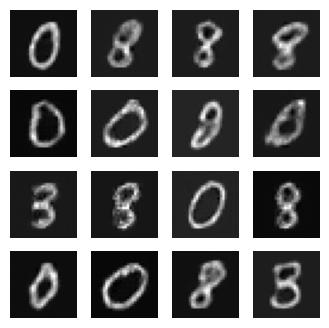

In [23]:
train(train_dataset, epochs)

In [26]:
import PIL

def display_image(epoch_no):
  return PIL.Image.open(f'generated_images/image_at_epoch_{epoch_no}.png')

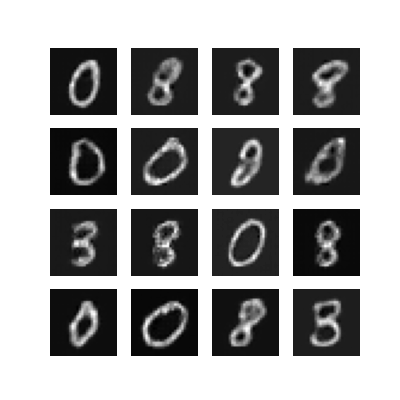

In [27]:
display_image(epochs)